Define function 'circles' that will plot coral colonies as circles using matplotlib
From here: http://stackoverflow.com/questions/9081553/python-scatter-plot-size-and-style-of-the-marker/24567352#24567352


In [303]:
import math as m
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import csv
%matplotlib inline

def circles(x, y, s, c='b', ax=None, vmin=None, vmax=None, **kwargs):
    """
    Make a scatter of circles plot of x vs y, where x and y are sequence 
    like objects of the same lengths. The size of circles are in data scale.

    Parameters
    ----------
    x,y : scalar or array_like, shape (n, )
        Input data
    s : scalar or array_like, shape (n, ) 
        Radius of circle in data scale (ie. in data unit)
    c : color or sequence of color, optional, default : 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs.
        Note that `c` should not be a single numeric RGB or
        RGBA sequence because that is indistinguishable from an array of
        values to be colormapped.  `c` can be a 2-D array in which the
        rows are RGB or RGBA, however.
    ax : Axes object, optional, default: None
        Parent axes of the plot. It uses gca() if not specified.
    vmin, vmax : scalar, optional, default: None
        `vmin` and `vmax` are used in conjunction with `norm` to normalize
        luminance data.  If either are `None`, the min and max of the
        color array is used.  (Note if you pass a `norm` instance, your
        settings for `vmin` and `vmax` will be ignored.)

    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`

    Other parameters
    ----------------
    kwargs : `~matplotlib.collections.Collection` properties
        eg. alpha, edgecolors, facecolors, linewidths, linestyles, norm, cmap

    Examples
    --------
    a = np.arange(11)
    circles(a, a, a*0.2, c=a, alpha=0.5, edgecolor='none')

    License
    --------
    This code is under [The BSD 3-Clause License]
    (http://opensource.org/licenses/BSD-3-Clause)
    """
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection
    #import matplotlib.colors as colors

    if ax is None:
        ax = plt.gca()    

    if isinstance(c,basestring):
        color = c     # ie. use colors.colorConverter.to_rgba_array(c)
    else:
        color = None  # use cmap, norm after collection is created
    kwargs.update(color=color)

    if isinstance(x, (int, long, float)):
        patches = [Circle((x, y), s),]
    elif isinstance(s, (int, long, float)):
        patches = [Circle((x_,y_), s) for x_,y_ in zip(x,y)]
    else:
        patches = [Circle((x_,y_), s_) for x_,y_,s_ in zip(x,y,s)]
    collection = PatchCollection(patches, **kwargs)

    if color is None:
        collection.set_array(np.asarray(c))
        if vmin is not None or vmax is not None:
            collection.set_clim(vmin, vmax)

    ax.add_collection(collection)
    return collection

class Coral(object):
    """Define a coral colony as a circle with a diameter, disease state, and x,y location"""
    def __init__(self, diameter, disease, loc):
        self.diameter = diameter
        self.area = sp.pi*(diameter/2.)**2.
        self.disease = disease
        self.x = loc[0]
        self.y = loc[1]   
    def IsDiseased(self):
        if self.disease==1:
            print "Diseased"
        else:
            print "Healthy"
            
class Landscape(object):
    """Define a reef landscape by its xy dimensions, mean & sd of the lognormal size freq dist, disease prevalence, and clumpiness
    
    reefdim: [x,y] dimensions in meters
    SFD: [mean,sd] of a lognormal size freq dist for coral colonies on the landscape
    prevalence: the probability that a colony on the landscape is diseased (if sizeprev==T, then slope of prev v diam(m))
    clump: not yet implemented; defaults to 0; will be a measure of the aggregation of colonies generated on the landscape
    
    Changes Needed: (1) BT and ET overestimate density bc of corners
                    (2) add more doc strings to methods
    """
    
    def __init__(self, reefdim, SFD, prevalence, sizeprev, clump=0):
        self.nCol = 0     #number of colonies
        self.reefdim = reefdim
        self.xreef = reefdim[0]   #length of reef in x direction (50m)
        self.yreef = reefdim[1]   #length of reef in y direction (10m)
        self.SFD = SFD
        self.SFDmu = SFD[0]   #mean of log(size) freq distribution of colonies (i.e., mean of log(diam/2))
        self.SFDsig = SFD[1] #sd of log(size) freq distribution of colonies (i.e., sd of log(diam/2))
        self.clump = clump   #clumpiness parameter (TBD)
        self.prevalence = prevalence #prob that a generated colony is diseased (or slope of prev v size)
        self.sizeprev = False  #if sizeprev is true, then prevalence is the slope of prev v diam(m)
        self.corals = []     #list of corals on this landscape
        
    def PredictCover(self, nc):
        maxS=7
        triesS=0
        while (maxS>=7) & (triesS < 10000):
            sizes = np.random.lognormal(self.SFDmu,self.SFDsig,nc)
            maxS= max(sizes)
            triesS += 1
        pcover = sum(np.pi*(sizes/2.)**2)/(self.xreef*self.yreef)
        return float(pcover)
    
    def PercentCover(self):
        s = self.AttrList("diameter")
        pcover = sum(np.pi*(s/2.)**2)/(self.xreef*self.yreef)
        return float(pcover)
    
    def PopPrevalence(self):
        d=0
        for i in range(self.nCol):
            if self.corals[i].disease==1:
                d += 1
        popprev = d/float(self.nCol)
        return popprev    
      
    def GenerateColonies(self, nc, counts=False, plot=0):
        start = time.clock()
        maxS=7
        triesS = 0
        #get a list nc coral sizes with max size lt 7m; abort if fail after 10000 tries 
        while (maxS>=7) & (triesS < 10000):
            sizes = -np.sort(-np.random.lognormal(self.SFDmu,self.SFDsig,nc))
            maxS= sizes[0]
            triesS += 1
        if (triesS == 10000):
            print "Reached 10000 SFD draws"    
            return 
        #generate a prob(dis==1) for each colony (equal if sizeprev==False, or size-dependent if sizeprev==True)
        if self.sizeprev==False:
            prev = np.repeat(self.prevalence,nc)
        if self.sizeprev==True:
            #prevalence increases linearly with size at rate self.prevalence; max is 0.99, min is 0
            prev = np.maximum(np.minimum(sizes*self.prevalence,0.99),0)
        if plot>0:
            nplot = np.floor(nc/plot)
        j = 0
        ct_rng = 0   #counter that increments for every random number generation
        ct_comp = 0  #counter that increments on every distance comparison
        rng = []
        comp = []
        while j <= (nc - 1):
            #get random location between x= (0,xreef), and y = 0, yreef)
            x_temp = np.random.uniform(low=0,high=self.xreef)  
            y_temp = np.random.uniform(low=0,high=self.yreef)
            ct_rng += 1  #increment counter each time a random location is generated
            i = 0
            overlap = 0
            while (i < j) & (overlap == 0):
                d = m.sqrt((self.corals[i].x - x_temp)**2 + (self.corals[i].y - y_temp)**2)
                if d < (sizes[j]/2 + self.corals[i].diameter/2):
                    overlap = 1
                i += 1
                ct_comp += 1  
            if overlap == 0:
                dis = np.random.binomial(1,prev[j])
                self.corals.append(Coral(sizes[j],dis,[x_temp,y_temp]))
                j += 1
                self.nCol = j
                if plot > 0:
                    if j%nplot == 0:
                        self.PlotLandscape() 
                rng.append(ct_rng)
                comp.append(ct_comp)
                ct_rng = 0 #reset counter for each new colony
                ct_comp = 0 #reset counter for each new colony
            if (ct_rng + 1)%1000000 ==0:
                print "ct_rng = " + str(ct_rng) + ", j = ", str(j)
            if ct_rng > self.nCol**3:
                print(["Stopped trying to place the ", j+1,"th colony after ",ct_rng," iterations"])
                break
        
        if counts is True:
            gentime = time.clock() - start
            print "{:.2f}".format(gentime) + " seconds to complete colony generation"
            print "Number of SFD draws is " + "{}".format(triesS)
            print "Predicted Cover is " + "{:.2f}".format(self.PredictCover(nc)*100) +"%"
            print "Percent Cover is " + "{:.2f}".format(self.PercentCover()*100) +"%"
            print "Population prevalence is " + "{:.4f}".format(self.PopPrevalence)
            plt.figure()
            plt.hist(self.AttrList("diameter"),30)
            #plt.figure()
            #plt.plot(rng)
            #plt.xlabel('Colony Num')
            #plt.ylabel('Number of Points generated before success')
            #plt.figure()
            #plt.plot(comp)
            #plt.xlabel('Colony Num')
            #plt.ylabel('Number of Distance Comparisons made before success')            
            
    
    def PlotLandscape(self, transect="none",**kwargs):
        from matplotlib.patches import Rectangle
        x = self.AttrList("x")
        y = self.AttrList("y")
        r = self.AttrList("diameter")/2.
        dis = self.AttrList("disease")
        disclr = []
        for i in range(self.nCol):
            if dis[i] == 1: 
                disclr.append("r")
            if dis[i] == 0:
                disclr.append("b")
        minorLocatorx = mpl.ticker.FixedLocator(range(0,self.xreef+1,1)) #for grid
        minorLocatory = mpl.ticker.FixedLocator(range(0,self.yreef+1,1))
        h=plt.figure(figsize = [3*self.xreef/self.yreef,3])
        ax = plt.gca()
        circles(x,y,r, edgecolor = disclr, facecolor='none')
        plt.title(str(self.nCol) + " colonies drawn from logNorm(" + str(self.SFDmu) + "," + str(self.SFDsig) +
                  ") and prev = " + str(self.prevalence))
        plt.xlim([0,self.xreef])
        plt.ylim([0,self.yreef])
        ax.xaxis.set_minor_locator(minorLocatorx)
        ax.yaxis.set_minor_locator(minorLocatory)
        plt.grid(b=True,which='both',axis='both')
        if transect == "BT":
            ax.add_patch(Rectangle([kwargs['stpt'][0],kwargs['stpt'][1] - kwargs['width']/2.],
                                   kwargs['length'],kwargs['width'], ec='b',fc='none', lw=2.))
            ax.text(self.xreef*.75,self.yreef*.75,
                    "Counted: " + str(kwargs['ctcols']) + "\nDiseased: " + str(kwargs['ctdis']),
                    bbox={'facecolor':'white'})
        if transect == "ET":
            ax.add_patch(Rectangle([kwargs['stpt'][0],kwargs['stpt'][1] - kwargs['ccwidth']/2.],
                                   kwargs['cclength'],kwargs['ccwidth'],ec='b',fc = 'none', lw=2.))
            ax.add_patch(Rectangle([kwargs['stpt'][0],kwargs['stpt'][1] - kwargs['dcwidth']/2.],
                                   kwargs['dclength'],kwargs['dcwidth'],ec='r', fc = 'none', lw=2.))
            ax.text(self.xreef*.75,self.yreef*.75,
                    "Est Count: " + str(kwargs['estcols']) + "\nDisease Count: " + str(kwargs['ctdis']),
                    bbox={'facecolor':'white'})
        if transect == "LI":
            plt.plot([kwargs['stpt'][0],kwargs['stpt'][0]+kwargs['length']],[kwargs['stpt'][1],kwargs['stpt'][1]], 
                     color='b', linestyle='-', linewidth=2)  
            ax.text(self.xreef*.75,self.yreef*.75,
                    "All Count: " + str(kwargs['ctcols']) + "\nDisease Count: " + str(kwargs['ctdis']),
                    bbox={'facecolor':'white'})

    def PlotSFD(self):
        d = self.AttrList("diameter")
        muhat = np.mean(np.log(d))
        sighat = np.std(np.log(d))
        plt.figure()
        plt.hist(d,30)
        plt.xlabel('Colony Diameter (m)')
        plt.title(["SFD drawn from: logN(" + str(self.SFDmu) + "," + str(self.SFDsig) + ")",
                   "(mu,sig)-hat = " + "{:.2f}".format(muhat) + ",","{:.2f}".format(sighat)])
        plt.figure()
        plt.hist(np.log(d),30)
        plt.xlabel('Log Colony Diameter (m)')
        plt.title(["SFD: logN(" + str(self.SFDmu) + "," + str(self.SFDsig) + 
                   "), (mu,sig)-hat = " + "{:.2f}".format(muhat) + ",","{:.2f}".format(sighat)])
        

    def BandTransect(self,stpt,length,width,plot=False): 
        if ((stpt[0] + length > self.xreef) | (stpt[1] + width/2. > self.yreef) | (stpt[1] - width/2. < 0)):
            return("Transect doesn't fit in landscape")
        if self.nCol ==0:
            return("No colonies on transect")
        ctcols=0
        #ctcols2=0
        ctdis=0
        for i in range(self.nCol):
            #want this to count only colonies >50% inside transect
            #first two lines include all colonies with stpt in transect
            #second two lines exclude colonies with stpt within 1/4*diameter of the corner
            #which (appoximately) excludes those with less than 1/2 area in the corners
            #this condition includes all colonies with x,y in the transect (overcounts corals in corners)
            x = self.corals[i].x
            y = self.corals[i].y
            r = self.corals[i].diameter/2
            inband = ((stpt[0] < x < stpt[0] + length)  
                    & (stpt[1] - width/2. < y < stpt[1] + width/2.))
            #this condition excludes corals with x,y within 1/4diameter of corners (approx correct)
            #inband2 = (((stpt[0] < x < stpt[0] + length)
            #           & (stpt[1] - width/2. + r/4. < y < stpt[1] + width/2. - r/4.))
            #          |((stpt[0] + r/4. < x < stpt[0] + length - r/4.)
            #           &(stpt[1] - width/2. < y < stpt[1] + width/2.)))
            if inband: 
                ctcols += 1
                if self.corals[i].disease == 1:
                    ctdis += 1
            #if inband2: 
            #    ctcols2 += 1
        if plot == True:
            self.PlotLandscape(transect="BT",stpt=stpt, length=length,width=width,ctcols=ctcols,ctdis=ctdis)
        #print "With corners, count1 = " + "{}".format(ctcols)
        #print "Without corners, count2 = " + "{}".format(ctcols2)
        return(ctcols, ctdis)
                                   
    def EstTransect(self,stpt,cclength,ccwidth,dclength,dcwidth,plot=False):
        # start point tuple, cc_length = coral count length, cc_width = coral count width
        # dc_length = disease count length, dc_width = disease count width
        if ((stpt[0] + cclength > self.xreef) | (stpt[1] + ccwidth/2. > self.yreef) | (stpt[1] - ccwidth/2. < 0) | \
            (stpt[0] + dclength > self.xreef) | (stpt[1] + dcwidth/2. > self.yreef) | (stpt[1] - dcwidth/2. < 0)):
            return("Transect doesn't fit in landscape")
        if self.nCol ==0:
            return("No colonies in landscape")
        ctcols=0
        ctdis=0
        for i in range(self.nCol):
            #want this to count only colonies >50% inside transect - ignore
            inCCband = ((stpt[0] < self.corals[i].x < stpt[0] + cclength) \
                     & (stpt[1] - ccwidth/2. < self.corals[i].y < stpt[1] + ccwidth/2.))
            inDCband = ((stpt[0] < self.corals[i].x < stpt[0] + dclength) \
                     & (stpt[1] - dcwidth/2. < self.corals[i].y < stpt[1] + dcwidth/2.))
            if inCCband:
                ctcols += 1
            if inDCband & self.corals[i].disease == 1:
                ctdis += 1
        #estimate number of cols in disease count area: coral count in a * (A/a)CC*(dcwidth*dclength)/(ccwidth*cclength)
        estcols = ctcols*(dclength*dcwidth)/(cclength*ccwidth)
        if plot == True:
            self.PlotLandscape(transect = "ET",stpt=stpt, cclength=cclength, ccwidth=ccwidth,
                               dclength=dclength, dcwidth=dcwidth, estcols=estcols,ctdis=ctdis)
        return(estcols, ctdis)
                                   
    def LineIntercept(self, stpt, length, plot=False): 
        if (stpt[0] + length > self.xreef):
            return("Transect doesn't fit in landscape")
        if self.nCol ==0:
            return("No colonies in landscape")
        ctcols = 0
        ctdis = 0
        for i in range(self.nCol):
            x_nearest = self.corals[i].x
            if self.corals[i].x > stpt[0] + length:
                x_nearest= stpt[0] + length
            elif self.corals[i].x < stpt[0]:
                x_nearest = stpt[0]
            ontransect = (m.sqrt((self.corals[i].y - stpt[1])**2) + (self.corals[i].x - x_nearest)**2) < self.corals[i].diameter/2.
            if ontransect:
                ctcols += 1
                if self.corals[i].disease == 1:
                    ctdis += 1
        if plot == True:
            self.PlotLandscape(transect = "LI",stpt=stpt, length=length, ctcols=ctcols,ctdis=ctdis)
        return(ctcols,ctdis)
    
    def AttrList(self,attr):
        """return list of attribute (attr) from all corals on landscape"""       
        if self.nCol ==0:
            print "No corals on landscape"
            a = 0
            return a
        if attr in ["diameter", "x", "y"]:
            a = np.empty([self.nCol,1],dtype=float)
        if attr is "disease":
            a = np.empty([self.nCol,1],dtype=int)
        for i in range(self.nCol):
            a[i] = getattr(self.corals[i],attr)
        return a
        
class SimLandscapes(object):
    """SimLandscapes(nLS,reefdim,SFD,prevalence,clump=0,infile) creates a set of landscapes with these characteristics
    reefdim: length,width of LS 
    SFD: lognormal size freq dist parameters
    prevalence
    clump
    
    Has functions to generate nLS landscapes and analyze/output landscapes
    """
    
    def __init__(self, nCol, reefdim, SFD, prevalence, clump=0):
        self.nCol = nCol  #number of colonies on the landscape
        self.reefdim = reefdim  #dimension of landscape in meters
        self.SFD = SFD   #mean and sd (in meters) of log-normal dist of colony diameter
        self.prevalence = prevalence #prob that a generated colony is diseased
        self.clump = clump   #clumpiness parameter (TBD)
        self.landscapes = []     #list of landscapes in this simulations
        self.nLS = 0

    def GenerateSims(self,nLS):
        self.nLS = nLS
        for i in range(nLS):
            self.landscapes.append(Landscape(self.reefdim,self.SFD,self.prevalence,self.clump))
            self.landscapes[i].GenerateColonies(self.nCol)
             
    def SampleSims(self, transect = "none", **kwargs):
        if transect == "none":
            print "Specify the type of transect for these sims"
        ctcols = []
        ctdis = []
        for i in range(self.nLS):           
            if transect== "BT":
                a = self.landscapes[i].BandTransect(kwargs['stpt'],kwargs['length'],kwargs['width'])
                ctcols.append(a[0])
                ctdis.append(a[1])
            if transect== "ET":
                a = self.landscapes[i].EstTransect(kwargs['stpt'],kwargs['cclength'],kwargs['ccwidth'],kwargs['dclength'],kwargs['dcwidth'])
                ctcols.append(a[0])
                ctdis.append(a[1])
            if transect== "LI":
                a = self.landscapes[i].LineIntercept(kwargs['stpt'],kwargs['length'])
                ctcols.append(a[0])
                ctdis.append(a[1])
        return (ctcols,ctdis)                
    
    def OutputSims(self, transects=["BT","ET","LI"],BTstpt=[5,5],BTlength=25,BTwidth=2,
                         ETstpt=[5,5],ETcclength=5,ETccwidth=2,ETdclength=25,ETdcwidth=10,
                         LIstpt=[5,5],LIlength=25,outfile = "SimsOut.txt", rwcode = 'wb'):
        if "BT" in transects:
            [BTctcols,BTctdis] = self.SampleSims(transect = "BT",stpt = BTstpt, length=BTlength,width=BTwidth)
        if "ET" in transects:
            [ETctcols,ETctdis] = self.SampleSims(transect = "ET",stpt = ETstpt, cclength=ETcclength,ccwidth=ETccwidth,dclength=ETdclength,dcwidth=ETdcwidth)
        if "LI" in transects:
            [LIctcols,LIctdis] = self.SampleSims(transect = "LI",stpt = LIstpt, length=LIlength)

        with open('SimsOut.csv',rwcode) as fout:
            fwriter = csv.writer(fout, quoting = csv.QUOTE_NONE,escapechar='\\')
            fwriter.writerow(["nCol","PercentCover","xreef","yreef","SFDmu","SFDsig","prevalence","SizeDepPrev?","PoplnPrevalence",
                                  "BTstptx","BTstpty","BTlength","BTwidth","BTctcols","BTctdis",
                                  "ETstptx","ETstpty","ETcclength","ETccwidth","ETdclength","ETdcwidth","ETctcols","ETctdis",
                                  "LIstptx","LIstpty","LIlength","LIctcols","LIctdis"])
            for i in range(self.nLS):
                fwriter.writerow([self.landscapes[i].nCol, '{:0.5f}'.format(self.landscapes[i].PercentCover()),
                                  self.landscapes[i].xreef, self.landscapes[i].yreef,
                                  self.landscapes[i].SFDmu, self.landscapes[i].SFDsig,
                                  self.landscapes[i].prevalence,self.landscapes[i],sizeprev,self.landscapes[i].PopPrevalence(),
                                  BTstpt[0],BTstpt[1],BTlength,BTwidth,BTctcols[i],BTctdis[i],
                                  ETstpt[0],ETstpt[1],ETcclength,ETccwidth,ETdclength,ETdcwidth,ETctcols[i],ETctdis[i],
                                  LIstpt[0],LIstpt[1],LIlength,LIctcols[i],LIctdis[i]])

In [344]:
#How many colonies do I need to generate for a given percent cover?
SFD = [[-3.5,1.8],[-1.5,0.2],[-0.8,0.8]]
ncs = [500,1250,2500,5000,7500]
reps = 20
reefdim=[50,15]
predict = np.empty(shape=(len(SFD),len(ncs),reps))
for i in range(len(SFD)):
    for j in range(len(ncs)): 
        n=0
        while (n<reps):
            L = Landscape(reefdim,SFD[i],0,False)       
            p = L.PredictCover(ncs[j])
            if p>0:
                predict[i][j][n] =p
                n +=1
       

In [362]:
for i in range(len(SFD)):
    for j in range(len(ncs)): 
        plt.figure()
        #plt.hist(predict[i][j])
        print "SFD=",SFD[i],"nc=",ncs[j],"mean&std %C=","{:.2f}".format(np.mean(predict[i][j])),"{:.2f}".format(np.std(predict[i][j]))


SFD= [-3.5, 1.8] nc= 500 meanPC= 0.09 0.04
SFD= [-3.5, 1.8] nc= 1250 meanPC= 0.22 0.05
SFD= [-3.5, 1.8] nc= 2500 meanPC= 0.42 0.08
SFD= [-3.5, 1.8] nc= 5000 meanPC= 0.85 0.10
SFD= [-3.5, 1.8] nc= 7500 meanPC= 3.85 5.39
SFD= [-1.5, 0.2] nc= 500 meanPC= 0.03 0.00
SFD= [-1.5, 0.2] nc= 1250 meanPC= 0.07 0.00
SFD= [-1.5, 0.2] nc= 2500 meanPC= 0.14 0.00
SFD= [-1.5, 0.2] nc= 5000 meanPC= 0.28 0.00
SFD= [-1.5, 0.2] nc= 7500 meanPC= 0.42 0.00
SFD= [-0.8, 0.8] nc= 500 meanPC= 0.38 0.05
SFD= [-0.8, 0.8] nc= 1250 meanPC= 0.91 0.06
SFD= [-0.8, 0.8] nc= 2500 meanPC= 1.86 0.08
SFD= [-0.8, 0.8] nc= 5000 meanPC= 3.65 0.14
SFD= [-0.8, 0.8] nc= 7500 meanPC= 5.55 0.15


In [343]:


#print predict
#print SFD
#print reefdim
#for i in range(len(SFD)):
#    L01 = Landscape(reefdim,SFD[i],0.4,True)
#    L01.GenerateColonies(2500, counts = False, plot= 1)
#    L01.PlotSFD


3.0
0.0772437445685


In [ ]:
L01 = Landscape([50,10],[-1.5,0.2],0.4,True)
L01.GenerateColonies(20000, counts = False, plot= 1)
[a,b]= L01.BandTransect([5,5],25,2,plot=False)
print a, b
print L01.EstTransect([5,5],10,1,25,4,plot=False)
print L01.LineIntercept([5,5],25,plot=False)
print L01.PopPrevalence()
print L01.PercentCover()
L01.PlotSFD()


In [302]:
SFD = [[-3.5,1.8],[-1.5,0.2],[-0.8,0.8]]
ncs = [500,1250,2500,5000,7500, 10000]
for i in range(3):
    for j in range(len(ncs)):
        d = np.random.lognormal(SFD[i],ncs[j])
        print "SFD=",SFD[i],"nc=",ncs[j],"area=","{:.2f}".format(sum(np.pi*(d/2)**2))

SFD= [-3.5, 1.8] nc= 500 area= 383.58
SFD= [-3.5, 1.8] nc= 1250 area= inf
SFD= [-3.5, 1.8] nc= 2500 area= inf
SFD= [-3.5, 1.8] nc= 5000 area= 0.00
SFD= [-3.5, 1.8] nc= 7500 area= inf
SFD= [-3.5, 1.8] nc= 10000 area= inf
SFD= [-1.5, 0.2] nc= 500 area= inf
SFD= [-1.5, 0.2] nc= 1250 area= inf
SFD= [-1.5, 0.2] nc= 2500 area= 0.00
SFD= [-1.5, 0.2] nc= 5000 area= inf
SFD= [-1.5, 0.2] nc= 7500 area= 0.00
SFD= [-1.5, 0.2] nc= 10000 area= inf
SFD= [-0.8, 0.8] nc= 500 area= inf
SFD= [-0.8, 0.8] nc= 1250 area= inf
SFD= [-0.8, 0.8] nc= 2500 area= inf
SFD= [-0.8, 0.8] nc= 5000 area= 0.00
SFD= [-0.8, 0.8] nc= 7500 area= 0.00
SFD= [-0.8, 0.8] nc= 10000 area= inf


C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: overflow encountered in square


In [126]:
S = SimLandscapes(nCol=100,reefdim=[50,10],SFD=[-1,0.5],prevalence=0.2)
S.GenerateSims(50)
S.OutputSims()



In [5]:
#Test Coral object
c01 = Coral(14,0,[3.21,4.445])
print c01.disease
c01.IsDiseased()
print c01.x
print c01.y
print c01.__doc__

0
Healthy
3.21
4.445
Define a coral colony as a circle with a diameter, disease state, and x,y location


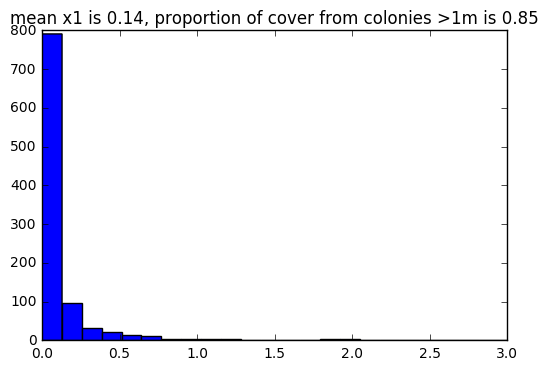

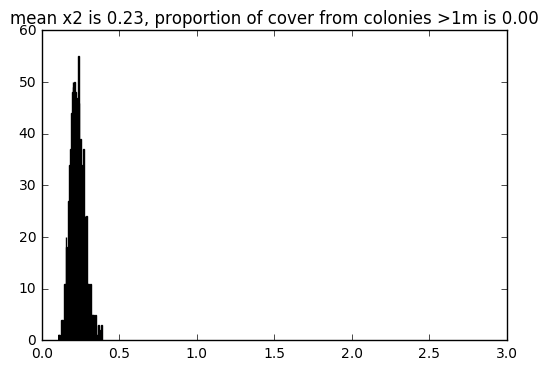

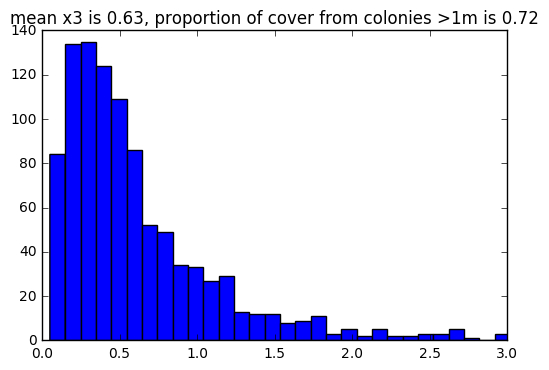

In [279]:
lnx1 = np.random.normal(-3.5,1.8,1000)
x1 = np.exp(lnx1)
x1gt1 = (sum(np.pi*x1[x1<7]**2) - sum(np.pi*(x1[x1<1])**2))/sum(np.pi*(x1[x1<7]**2))

lnx2 = np.random.normal(-1.5,0.2,1000)
x2 = np.exp(lnx2)
x2gt1 = (sum(np.pi*x2[x2<7]**2) - sum(np.pi*(x2[x2<1])**2))/sum(np.pi*(x2[x2<7]**2))

lnx3 = np.random.normal(-0.8,0.8,1000)
x3 = np.exp(lnx3)
x3gt1 = (sum(np.pi*x3[x3<7]**2) - sum(np.pi*(x3[x3<1])**2))/sum(np.pi*(x3[x3<7]**2))

plt.figure()
plt.hist(x1,50)
plt.xlim([0,3])
plt.title("mean x1 is " + "{:.2f}".format(np.mean(x1)) + ", proportion of cover from colonies >1m is " + "{:.2f}".format(x1gt1))

plt.figure()
plt.hist(x2,50)
plt.xlim([0,3])
plt.title("mean x2 is " + "{:.2f}".format(np.mean(x2)) + ", proportion of cover from colonies >1m is " + "{:.2f}".format(x2gt1))

plt.figure()
plt.hist(x3,50)
plt.xlim([0,3])
plt.title("mean x3 is " + "{:.2f}".format(np.mean(x3)) + ", proportion of cover from colonies >1m is " + "{:.2f}".format(x3gt1))


(array([ 360.,  263.,  129.,   68.,   57.,   28.,   15.,   12.,   14.,
           8.,    6.,    6.,   10.,    3.,    6.,    2.,    2.,    2.,
           1.,    0.,    1.,    0.,    0.,    1.,    0.,    0.,    1.,
           1.,    0.,    1.,    0.,    1.,    0.,    0.,    0.,    0.,
           1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([  1.13357426e-03,   7.52095520e-02,   1.49285530e-01,
          2.23361507e-01,   2.97437485e-01,   3.71513463e-01,
          4.45589441e-01,   5.19665418e-01,   5.93741396e-01,
          6.67817374e-01,   7.41893352e-01,   8.15969329e-01,
          8.90045307e-01,   9.64121285e-01,   1.03819726e+00,
          1.11227324e+00,   1.18634922e+00,   1.26042520e+00,
          1.33450117e+00,   1.40857715e+00,   1.48265313e+00,
          1.55672911e+00,   1.63080508e+00,   1.70488106e+00,
          1.77895704e+00,   1.85303302e+00,   1.92710900e+00,
          2.00118497e+00,   2.07526095e+00

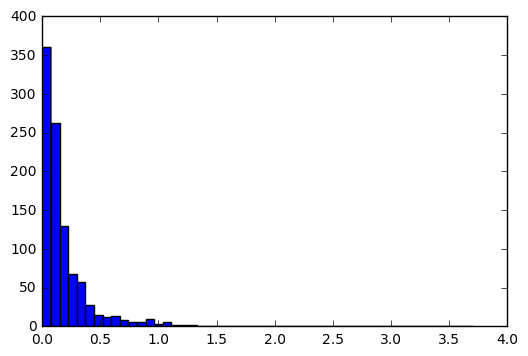

In [294]:
#L01 = Landscape([50,10],[-2.25,1.1],0.4,sizeprev=True)
#L01.GenerateColonies(500, counts = False, plot= 1)
#print L01.PercentCover()
#L01.PlotSFD()

x=np.random.lognormal(-2.25,1.1,1000)
plt.figure()
plt.hist(x,50)
 
    